# Stock Price Prediction Based on News Sentiment
- [Repository](https://github.com/hish-school-work/Math509-project)

## Group Members:
- Chetan Dhingra (1862481)
- Hish Salehi (1812352)
- Velda Iskandar (1882870)

### Step 1: Install Required Libraries

We begin by installing the necessary Python packages. `yfinance` is used to fetch historical stock data from Yahoo Finance, `pandas` for data manipulation, and `matplotlib` for future visualizations.


In [1]:
!pip install yfinance matplotlib pandas


### Step 2: Download Tesla Stock Price Data (2015–2019)

Here, we use the `yfinance` package to download daily stock data for Tesla (ticker symbol: TSLA) from January 1, 2015, to December 31, 2019. This will serve as the foundation for our analysis of how news sentiment correlates with stock price movements.


In [2]:
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd

# Define Tesla stock ticker and date range
ticker = "TSLA"
start_date = "2015-01-01"
end_date = "2019-12-31"

# Fetch daily stock price data
tesla_stock = yf.download(ticker, start=start_date, end=end_date)

# Preview result
tesla_stock.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500


### Step 3: Check for MultiIndex Columns

After downloading the data, we print the column structure to inspect if the DataFrame has a MultiIndex. This happens occasionally with certain formats from `yfinance`, and we’ll need to flatten the index in the next step to simplify further processing.


In [3]:
tesla_stock.columns

MultiIndex([( 'Close', 'TSLA'),
            (  'High', 'TSLA'),
            (   'Low', 'TSLA'),
            (  'Open', 'TSLA'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])

In [4]:
# Flatten MultiIndex: keep just the first level (like 'Close', 'High', etc.)
tesla_stock.columns = tesla_stock.columns.get_level_values(0)

# Reset index to bring 'Date' back as a column
tesla_stock = tesla_stock.reset_index()

# Rename column if needed
tesla_stock = tesla_stock.rename(columns={"Close": "adj_close"})

tesla_stock.head()

Price,Date,adj_close,High,Low,Open,Volume
0,2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000
1,2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500
2,2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500
3,2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000
4,2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500


In [5]:
# Calculate daily returns
tesla_stock['return'] = tesla_stock['adj_close'].pct_change()

# Drop NaN from the first row
tesla_stock = tesla_stock.dropna().reset_index(drop=True)

# Preview cleaned data
tesla_stock.head()

Price,Date,adj_close,High,Low,Open,Volume,return
0,2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500,-0.042041
1,2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500,0.005664
2,2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000,-0.001562
3,2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500,-0.001564
4,2015-01-09,13.777333,13.998667,13.664000,13.928000,70024500,-0.018802


### Step 4: Visualize Tesla Stock Price and Returns

Before diving into sentiment modeling, we visualize Tesla’s stock performance to understand the data’s behavior. The first plot shows the adjusted close price over time, revealing long-term trends and shifts. The second plot highlights daily percentage returns, which help detect periods of high volatility. Finally, a histogram of returns allows us to assess their distribution, an important aspect for later modeling.


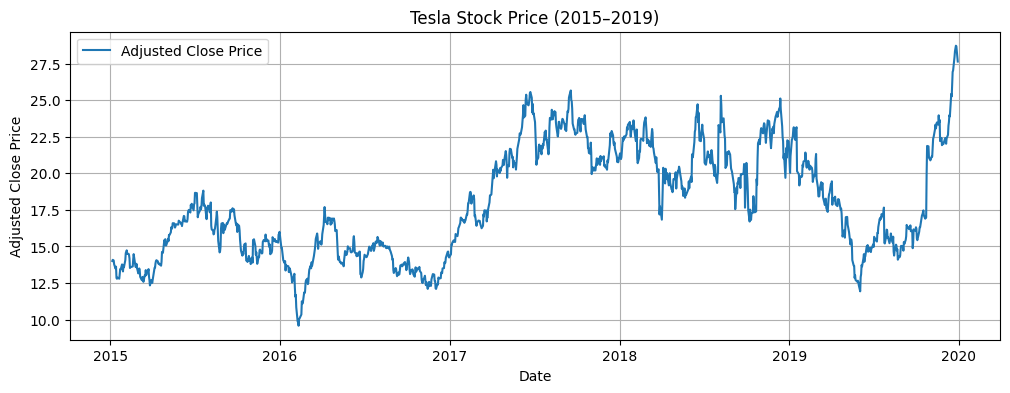

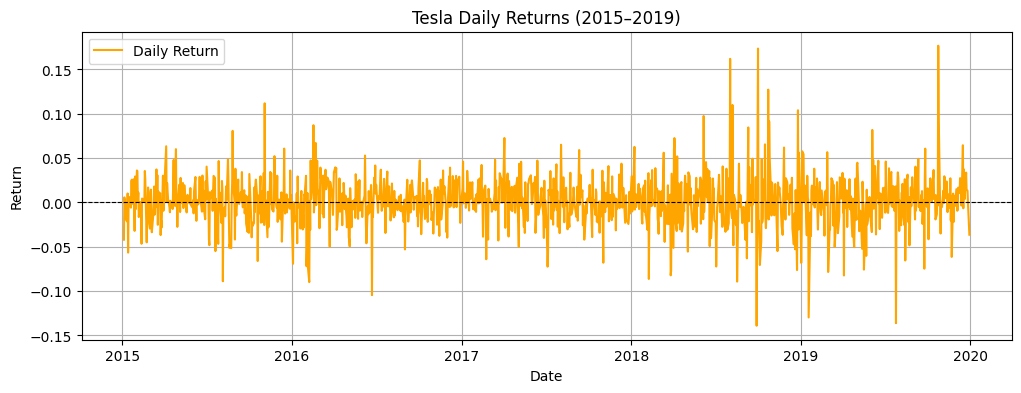

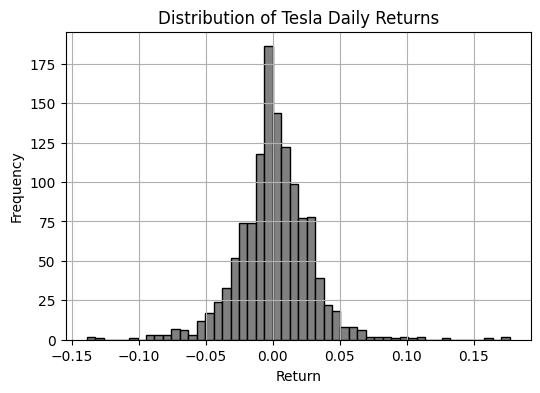

In [6]:
import matplotlib.pyplot as plt

# Plot adjusted close price
plt.figure(figsize=(12, 4))
plt.plot(tesla_stock['Date'], tesla_stock['adj_close'], label='Adjusted Close Price')
plt.title('Tesla Stock Price (2015–2019)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.grid(True)
plt.legend()
plt.show()

# Plot daily returns
plt.figure(figsize=(12, 4))
plt.plot(tesla_stock['Date'], tesla_stock['return'], color='orange', label='Daily Return')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Tesla Daily Returns (2015–2019)')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)
plt.legend()
plt.show()

# Optional: histogram of returns
plt.figure(figsize=(6, 4))
plt.hist(tesla_stock['return'], bins=50, color='gray', edgecolor='black')
plt.title('Distribution of Tesla Daily Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


The plots are helpful to understand the behavior of Tesla's stock between 2015 and 2019. The adjusted close price shows a long period of relative stability followed by an abrupt spurt in late 2019, which hints at potential periods where market sentiment could have played a greater role. The plot of daily return shows consistent short-term volatility with high peaks in volatility, which are ideal for studying the impact of sentiment. Also, the return histogram exhibits a distribution about zero with small tails, which justifies the application of a normal distribution in modeling, as well as hinting at the occasional large movements. All these findings together justify the application of sentiment-based predictive modeling and motivate further investigation with Bayesian inference techniques.



### Step 5: Load and Inspect Raw Tweet Dataset

We load the full tweet dataset to examine its structure. This dataset contains tweets from multiple users between 2015 and 2019. We check the available columns to understand what information we can use, including the tweet content, time of posting, and engagement metrics like retweets and likes.


In [7]:
# Install dependencies as needed:
! pip install kagglehub[pandas-datasets]

In [8]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "Tweet.csv"

# Load the latest version
tweets_df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "omermetinn/tweets-about-the-top-companies-from-2015-to-2020",
  file_path,
)

# Preview the columns
print(tweets_df.columns)

tweets_df.head()

<ipython-input-8-6f199b4c3017>:8: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  tweets_df = kagglehub.load_dataset(


Index(['tweet_id', 'writer', 'post_date', 'body', 'comment_num', 'retweet_num',
       'like_num'],
      dtype='object')


,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


### Step 6: Filter for Tesla-Related Tweets and Parse Dates

From the full dataset, we extract only the tweets that are relevant to Tesla by searching for keywords like "TSLA", "Tesla", or "Elon Musk". Then, we convert the UNIX timestamp (`post_date`) into a readable datetime format, which allows us to align tweets with stock data on a daily basis. We preview the cleaned subset to verify that the filtering worked correctly.


In [9]:
# Filter for Tesla-related tweets (case-insensitive)
tesla_tweets = tweets_df[
    tweets_df['body'].str.contains("TSLA|Tesla|Elon Musk|EV|Electric Vehicle", case=False, na=False)
].copy()

# Convert post_date (UNIX timestamp) to datetime
tesla_tweets['date'] = pd.to_datetime(tesla_tweets['post_date'], unit='s')

# Preview cleaned Tesla tweets
tesla_tweets[['date', 'body']].head()

,date,body
3,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...
4,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...
5,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...
6,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...
7,2015-01-01 00:10:16,Swing Trading: Up To 8.91% Return In 14 Days h...


## Sentiment Analysis

### Step 1

In [10]:
! pip install vaderSentiment tqdm pyarrow

In [11]:
from google.colab import drive
drive.mount('/content/drive')

# Make sure the save_path is correct for your drive
# Otherwise it would run for ~ 4 hours to do the sentiment analysis again
save_path = '/content/drive/MyDrive/tesla_sentiment_analysis.parquet'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.auto import tqdm  # Progress bar library
import os

def analyze_sentiment(text):
    """
    Perform sentiment analysis using VADER

    Args:
        text (str): Tweet text

    Returns:
        dict: Sentiment scores
    """
    # Ensure text is a string and not NaN
    if not isinstance(text, str):
        return {
            'vader_compound': 0,
            'vader_positive': 0,
            'vader_negative': 0,
            'sentiment_category': 'Neutral'
        }

    # Initialize VADER analyzer
    vader_analyzer = SentimentIntensityAnalyzer()

    # Get VADER sentiment scores
    vader_scores = vader_analyzer.polarity_scores(text)

    # Categorize sentiment
    if vader_scores['compound'] >= 0.05:
        sentiment_category = 'Positive'
    elif vader_scores['compound'] <= -0.05:
        sentiment_category = 'Negative'
    else:
        sentiment_category = 'Neutral'

    return {
        'vader_compound': vader_scores['compound'],
        'vader_positive': vader_scores['pos'],
        'vader_negative': vader_scores['neg'],
        'sentiment_category': sentiment_category
    }


def perform_sentiment_analysis(tweets_df, save_path=save_path):
    """
    Perform sentiment analysis on a DataFrame of tweets with progress tracking

    Args:
        tweets_df (pd.DataFrame): DataFrame with tweet data
        save_path (str): Path to save sentiment analysis results

    Returns:
        dict: Dictionary with processed tweets and daily sentiment
    """
    # Check if saved results exist
    if os.path.exists(save_path):
        print(f"Loading existing sentiment analysis from {save_path}")
        processed_tweets = pd.read_parquet(save_path)

        # Compute daily sentiment
        daily_sentiment = processed_tweets.groupby(processed_tweets['date'].dt.date).agg({
            'vader_compound': 'mean',
            'sentiment_category': lambda x: x.value_counts().index[0],
            'body': 'count'
        }).rename(columns={'body': 'tweet_count'})

        return {
            'processed_tweets': processed_tweets,
            'daily_sentiment': daily_sentiment
        }

    # Filter Tesla-related tweets
    tesla_tweets = tweets_df[
        tweets_df['body'].str.contains("TSLA|Tesla|Elon Musk|EV|Electric Vehicle", case=False, na=False)
    ].copy()

    # Convert post_date to datetime
    tesla_tweets['date'] = pd.to_datetime(tesla_tweets['post_date'], unit='s')

    # Prepare progress bar
    tqdm.pandas(desc="Analyzing Tweet Sentiments")

    # Vectorized sentiment analysis with progress bar
    sentiment_results = tesla_tweets['body'].progress_apply(analyze_sentiment)

    # Expand sentiment columns
    tesla_tweets['vader_compound'] = sentiment_results.apply(lambda x: x['vader_compound'])
    tesla_tweets['vader_positive'] = sentiment_results.apply(lambda x: x['vader_positive'])
    tesla_tweets['vader_negative'] = sentiment_results.apply(lambda x: x['vader_negative'])
    tesla_tweets['sentiment_category'] = sentiment_results.apply(lambda x: x['sentiment_category'])

    # Save results to Parquet for faster future loading
    tesla_tweets.to_parquet(save_path, index=False)
    print(f"Sentiment analysis results saved to {save_path}")

    # Daily sentiment summary
    daily_sentiment = tesla_tweets.groupby(tesla_tweets['date'].dt.date).agg({
        'vader_compound': 'mean',
        'sentiment_category': lambda x: x.value_counts().index[0],
        'body': 'count'
    }).rename(columns={'body': 'tweet_count'})

    return {
        'processed_tweets': tesla_tweets,
        'daily_sentiment': daily_sentiment
    }

In [13]:
results = perform_sentiment_analysis(tweets_df)

Loading existing sentiment analysis from /content/drive/MyDrive/tesla_sentiment_analysis.parquet


In [14]:
results_df = pd.DataFrame(results['daily_sentiment'])
results_df.columns

Index(['vader_compound', 'sentiment_category', 'tweet_count'], dtype='object')

## Exploratory Data Analysis (EDA)

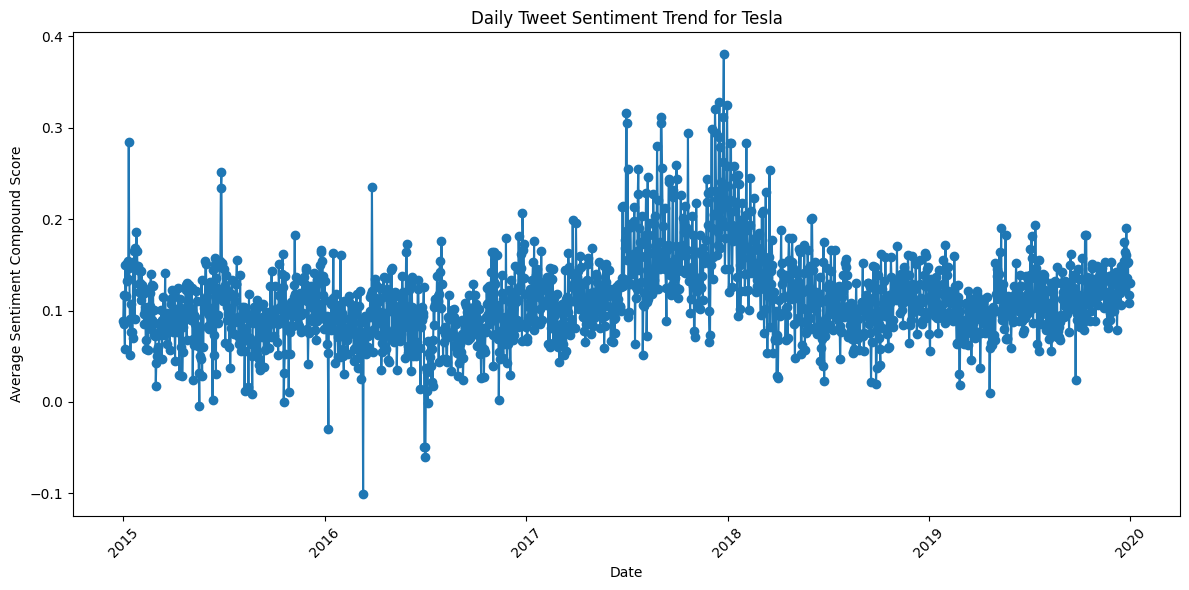

In [15]:
def plot_sentiment_trends(daily_sentiment):
    """
    Create a visualization of sentiment trends

    Args:
        daily_sentiment (pd.DataFrame): Daily sentiment summary
    """

    plt.figure(figsize=(12, 6))
    plt.plot(daily_sentiment.index, daily_sentiment['vader_compound'], marker='o')
    plt.title('Daily Tweet Sentiment Trend for Tesla')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Compound Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Sentiment trends
plot_sentiment_trends(results['daily_sentiment'])

### Aligned sentiment data with stock prices over time

In [16]:
# Convert the index of results_df to datetime objects
results_df.index = pd.to_datetime(results_df.index)

# Convert the 'Date' column of tesla_stock to datetime objects
tesla_stock['Date'] = pd.to_datetime(tesla_stock['Date'])

# Merge the two DataFrames on the date/index
aligned_df = pd.merge(tesla_stock, results_df, how='left', left_on='Date', right_index=True)

In [17]:
# Preview the merged DataFrame
aligned_df

,Date,adj_close,High,Low,Open,Volume,return,vader_compound,sentiment_category,tweet_count
0,2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500,-0.042041,0.149852,Neutral,452
1,2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500,0.005664,0.116036,Neutral,401
2,2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000,-0.001562,0.152005,Neutral,425
3,2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500,-0.001564,0.132511,Neutral,516
4,2015-01-09,13.777333,13.998667,13.664000,13.928000,70024500,-0.018802,0.153990,Neutral,470
...,...,...,...,...,...,...,...,...,...,...
1251,2019-12-23,27.948000,28.134001,27.333332,27.452000,199794000,0.033605,0.163641,Positive,2627
1252,2019-12-24,28.350000,28.364668,27.512667,27.890667,120820500,0.014384,0.161043,Positive,1386
1253,2019-12-26,28.729334,28.898666,28.423332,28.527332,159508500,0.013380,0.151944,Positive,1450
1254,2019-12-27,28.691999,29.020666,28.407333,29.000000,149185500,-0.001300,0.135329,Positive,1495


### Sentiment Distribution

In [18]:
import seaborn as sns
from scipy import stats

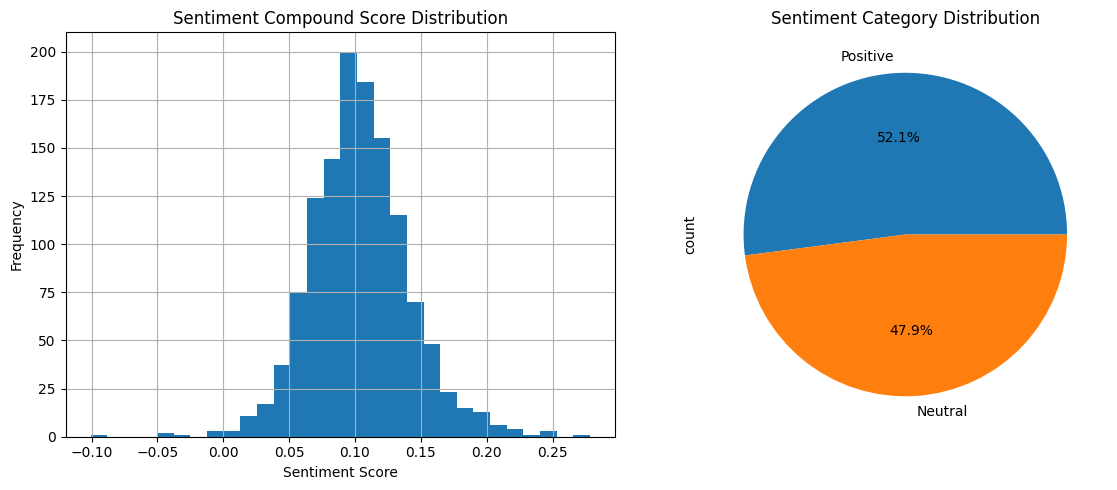

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
aligned_df['vader_compound'].hist(bins=30)
plt.title('Sentiment Compound Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
aligned_df['sentiment_category'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Sentiment Category Distribution')
plt.tight_layout()
plt.show()

### Correlation and Relationship Analysis

Correlation Matrix:
                vader_compound  adj_close    return
vader_compound        1.000000   0.417097  0.205881
adj_close             0.417097   1.000000  0.081621
return                0.205881   0.081621  1.000000


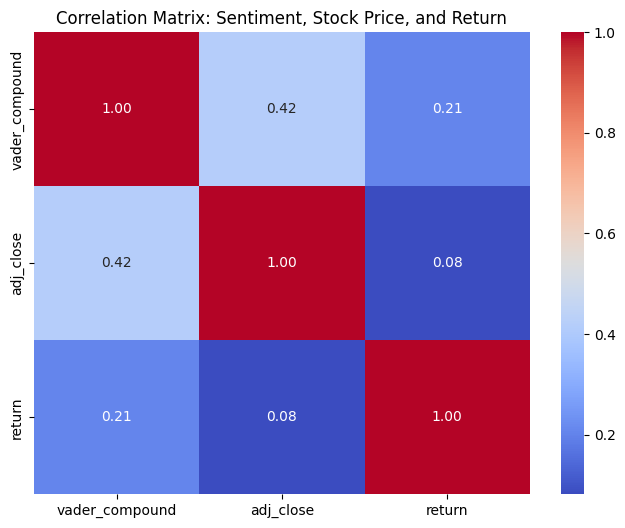

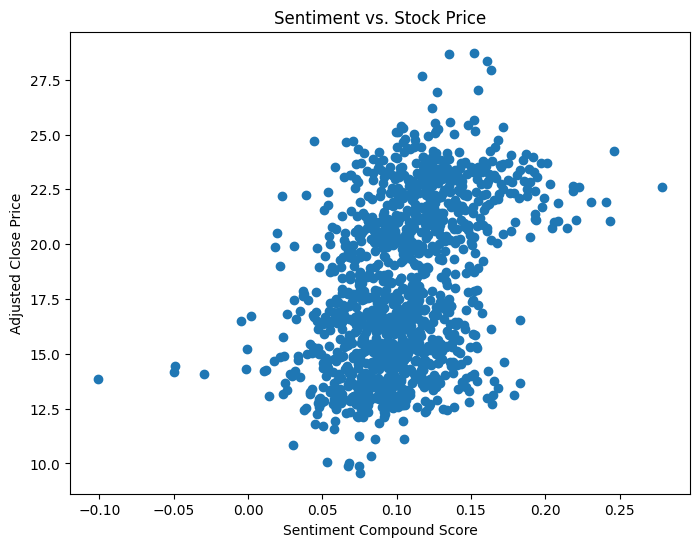

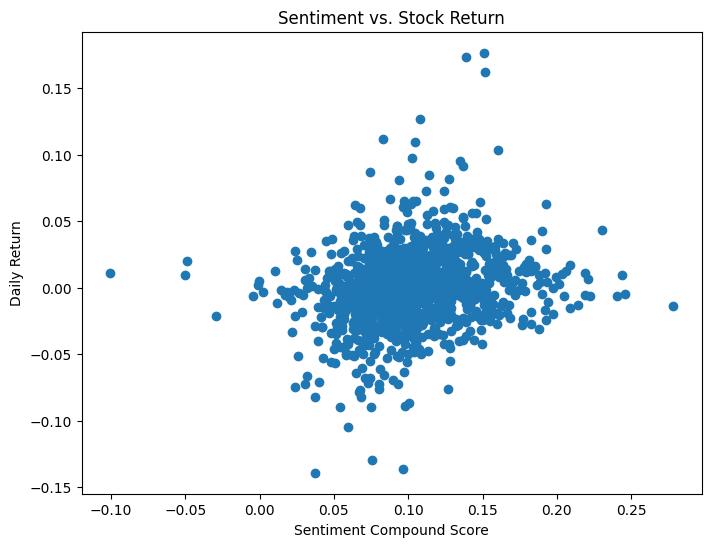

In [20]:
# Calculate the correlation between sentiment and stock metrics
correlation_matrix = aligned_df[['vader_compound', 'adj_close', 'return']].corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Sentiment, Stock Price, and Return')
plt.show()

# Scatter plot of sentiment vs. stock price
plt.figure(figsize=(8, 6))
plt.scatter(aligned_df['vader_compound'], aligned_df['adj_close'])
plt.title('Sentiment vs. Stock Price')
plt.xlabel('Sentiment Compound Score')
plt.ylabel('Adjusted Close Price')
plt.show()

# Scatter plot of sentiment vs. stock return
plt.figure(figsize=(8, 6))
plt.scatter(aligned_df['vader_compound'], aligned_df['return'])
plt.title('Sentiment vs. Stock Return')
plt.xlabel('Sentiment Compound Score')
plt.ylabel('Daily Return')
plt.show()

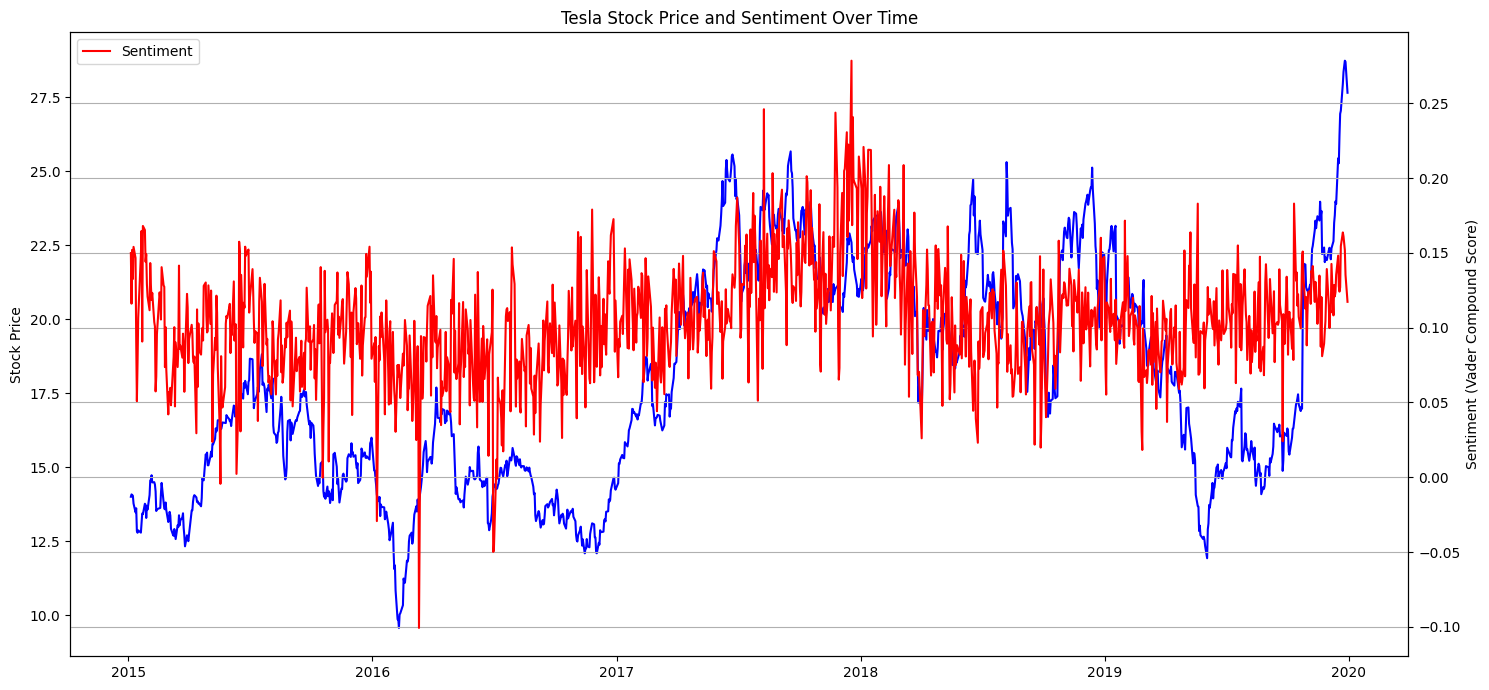

In [21]:
plt.figure(figsize=(15, 7))

# Plot stock price
plt.plot(aligned_df['Date'], aligned_df['adj_close'], label='Stock Price', color='blue')
plt.ylabel('Stock Price')

# Create a secondary y-axis for sentiment
ax2 = plt.twinx()
ax2.plot(aligned_df['Date'], aligned_df['vader_compound'], label='Sentiment', color='red')
ax2.set_ylabel('Sentiment (Vader Compound Score)')

# Customize plot
plt.title('Tesla Stock Price and Sentiment Over Time')
plt.xlabel('Date')
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Time Lag Analysis
This is to analyze the results to see which lag has the highest correlation, indicating the optimal time delay between sentiment and its impact on the stock price.


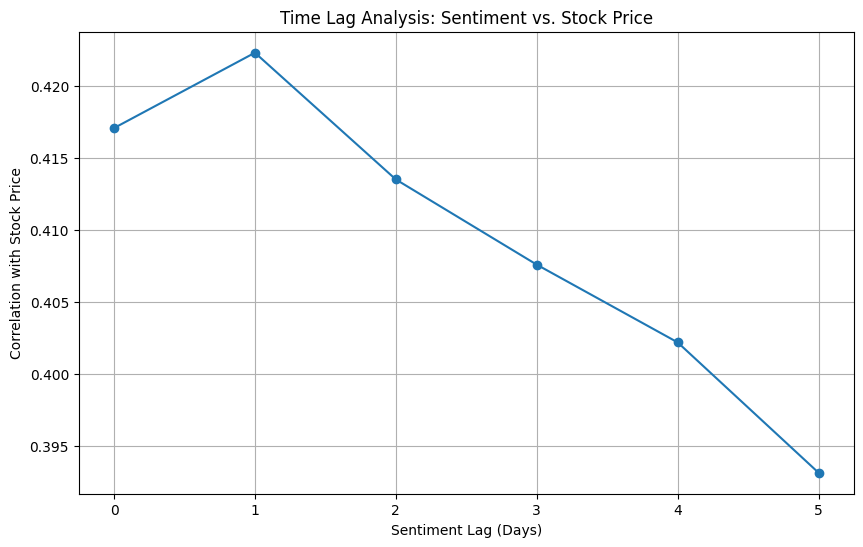

In [22]:
def time_lag_analysis(df, lag_days):
  """
  Performs time lag analysis between sentiment and stock price.

  Args:
    df: DataFrame with 'Date', 'adj_close', 'vader_compound' columns.
    lag_days: Number of days to lag sentiment data.

  Returns:
    A DataFrame with correlation results for each lag.
  """
  results = []
  for lag in range(lag_days + 1):
    df_copy = df.copy()
    df_copy['lagged_sentiment'] = df_copy['vader_compound'].shift(lag)
    correlation = df_copy['adj_close'].corr(df_copy['lagged_sentiment'])
    results.append({'Lag (days)': lag, 'Correlation': correlation})

  return pd.DataFrame(results)

# Example usage:
lag_days_to_analyze = 5  # Analyze lags from 0 to 5 days
correlation_results = time_lag_analysis(aligned_df, lag_days_to_analyze)

# Plot correlation results
plt.figure(figsize=(10, 6))
plt.plot(correlation_results['Lag (days)'], correlation_results['Correlation'], marker='o')
plt.xlabel('Sentiment Lag (Days)')
plt.ylabel('Correlation with Stock Price')
plt.title('Time Lag Analysis: Sentiment vs. Stock Price')
plt.grid(True)
plt.show()